# Bioimage Handling in Python for Beginners
*Author: Vladislav Kim*
* [Introduction](#intro)
* [Bioimage formats and loading](#load)
* [Viewing Images in Jupyter](#view)
* [Handling multichannel images in high-content screening](#compleximages)
* [Basic image transformations](#transform)
* [Writing images](#writeimg)


## Introduction
<a id="intro"></a> 
Before applying segmentation or a machine learning model on the imaging data set there may be a number of preprocessing steps that can transform the image and adjust numerous parameters such as brightness, contrast, noise. We may also want to combine or split color channels or apply filters that enhance or suppress certain image features.


In this notebook we show how to load a microscopy image in Python using `python-bioformats`. We load images as `numpy.array` objects. We also show how the images represented as `numpy.array` can be preprocessed using various transformations avaialbe in `scikit-image` library before downstream analysis, such as segmentation, is run.


The first step before running this notebook would be to set up a conda environment with all the dependencies (see README for instructions). Once the environment is set up, activate it and start jupyter server in the environment.


In [1]:
# load third-party Python modules
import javabridge
import bioformats as bf
import skimage
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

javabridge.start_vm(class_path=bf.JARS)

## Bioimage formats and data loading
<a id="load"></a> 
Open Microscopy Environment (OME), a consortium of research institutes and universities, supports 150 bioimage formats. Their Java library `bioformats` is available in Python. Among the supported formats we can find common formats such as TIFF, JPG and PNG, but also proprietary formats such as Zeiss CZI, Leica LCF, Canon DNG, etc


We provide an example of an image stack (download here [insert link] and unzip in the same directory as Jupyter notebook). The first step is to load microscopy images. The images that we will be working with are in TIFF format.

To read in a basic TIFF file, initialize a bioformats reader object and provide the file name:

In the local module `transform.basic` we provide a function `read_tiff` which is a wrapper that reads in the image and outputs a `numpy.array` object

In [2]:
from transform.basic import read_tiff
img_ho = read_tiff(fname='data/CLL-coculture/r01c02f01-Hoechst.tiff')

Image size: 2160 x 2160


Two-dimensional images can be represented as 2D numerical arrays (`np.array`) or matrices:

In [3]:
print(type(img_ho))
print(img_ho.shape)

<type 'numpy.ndarray'>
(2160, 2160)


## Viewing Images in Jupyter
<a id="view"></a> 

We can plot the image arrays using `mapltolib` as grey-scale images:

(-0.5, 2159.5, 2159.5, -0.5)

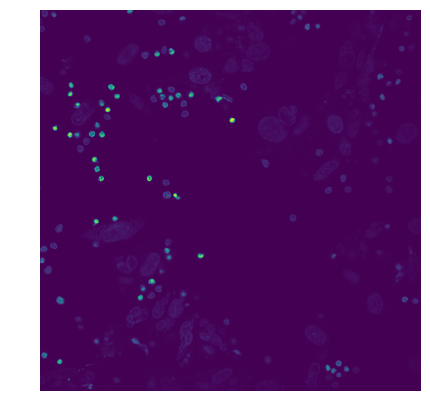

In [4]:
plt.figure(figsize=(7,7))
plt.imshow(img_ho)
plt.axis('off')

If a microscopy image has several channels, these can be plotted individually as grey-scale images side by side. Load another chanel of the same image:

In [5]:
img_ly = read_tiff(fname='data/CLL-coculture/r01c02f01-Ly.tiff')

Image size: 2160 x 2160


Side by side view:

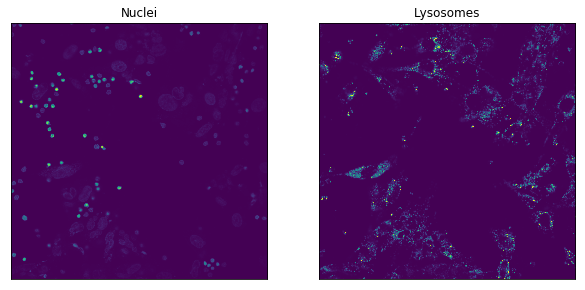

In [6]:
from visualize.plot_static import plot_channels
plot_channels([img_ho, img_ly], titles=['Nuclei', 'Lysosomes'], nrow=1, ncol=2)

Or combined as an RGB-overlaid image:

In [7]:
from visualize.plot_static import combine_channels
# here we use gamma correction for 'img_ho'
img_overlay = combine_channels([img_ho**0.5, img_ly],
                               colors=['blue', 'white'],
                               blend = [1.5, 0.7])

(-0.5, 2159.5, 2159.5, -0.5)

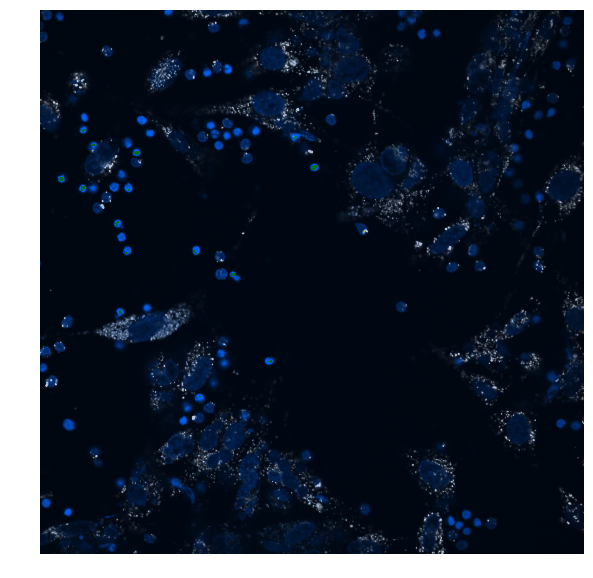

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(img_overlay)
plt.axis('off')

## Handling compound multichannel images (high-content screening)
<a id="compleximages"></a> 
In addition to color information, microscopy images may have optical sections along the $z$-axis. Handling 3D multichannel data is trivial in Python, as these can be represented as (3D+color)-`np.array`. We can load one such image using `load_imgstack` function

In [9]:
from transform.basic import load_imgstack
imgstack = load_imgstack(fname="data/BiTE/Tag2-r04c02f1.tiff")

The convention is that the first dimension is reserved for optical sections ($z$-stack), the next two dimensions describe image coordinates ($xy$-plane) and the last dimension is for channel information. 

First we can use maximum intensity projection (MIP) to aggregate images along the $z$-direction and make them two-dimensional (+ color)

In [12]:
mip = np.amax(imgstack, axis=0)
print(mip.shape)

(1080, 1080, 4)


As mentioned before channels are in the last array axis (dimension), we can split the color channels and plot them side by side:

In [16]:
# split individual color channels and place them in a list
mip_split = [mip[:,:,i] for i in range(mip.shape[2])]

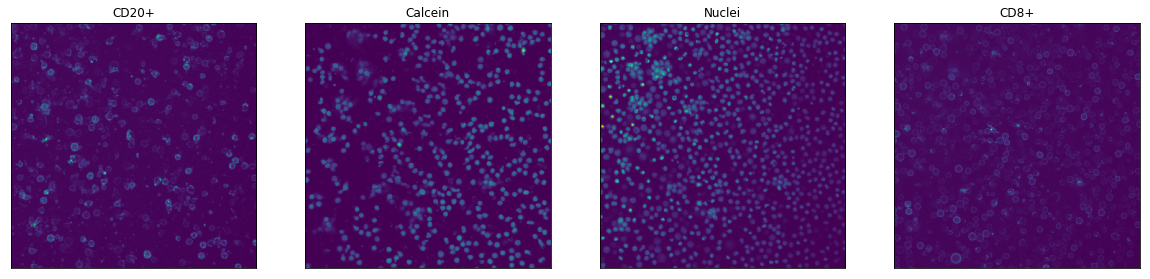

In [72]:
plot_channels(mip_split,
              nrow=1, ncol=4,
              titles=['CD20+', 'Calcein',
                      'Nuclei', 'CD8+'])

In [81]:
mip_color = combine_channels(mip_split, 
                             colors=['red', 'green',
                                     'blue','orange'],
                             # these are optional (see documentation)
                             blend = [0.8, 0.8, 2, 0.8],
                             gamma = [0.3, 0.3, 0.4, 0.3])

(-0.5, 1079.5, 1079.5, -0.5)

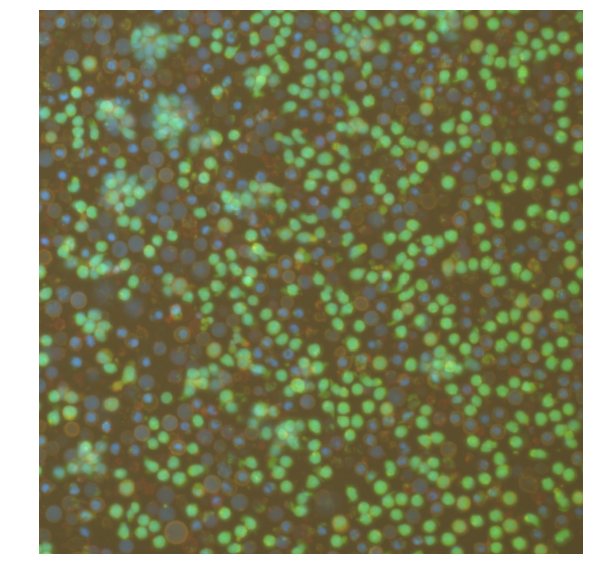

In [82]:
plt.figure(figsize=(10,10))
plt.imshow(mip_color)
plt.axis('off')

*You can skip 'Applications to High-Content Screening' upon first reading*

### Applications to High-Content Screening
Some microscopes output a series of images instead of a single image stack. We can use the function `transform.basic.load_image_series` to load all the color channels and $z$-stack in a single `numpy.array`.


Here we will load a series of images from a high-content screen. Wells of a 384-well plate are numbered (r01 = row 1, c16 = column 16) and we would like to load a single well that has 
+ 3 color channels
+ 7 optical sections ($z$-stack)
+ 3 fields of view (sampled positions in the $xy$-plane at which the well was imaged)

Suppose we want to load well 'r01c02' and only the first field of view ('f01'):

In [ ]:
# list files
files = os.listdir("data/AML_screen")

In [ ]:
# well r01c02, position 1 (f01)
well = [re.search('r01c02f01', f).group() for f in files]

## Basic image transformations
<a id="transform"></a> 
After the images have been loaded and inspected, they can be transformed. To name a few image transformations:
+ adjust brightness and contrast
+ rescale image
+ remove background
+ denoise / introduce Gaussian blur
+ separate foreground from background (threshold)

Here we will talk about the most basic image transformations such as contrast adjustment and rescaling (see 'Advanced Image Processing' notebook for the detailed treatment of image transformations).

Perhaps the most trivial image transformation is image inversion (obtaining the "negative" of the image)

A useful feature is image rescaling, which can be achieved by `skimage.transform.resize`:

To adjust brightness of an image, one may have to apply gamma correction to the image, which simply raises the `np.array` to the power of `gamma`

The best is always to compare the original and transformed image side-by-side:

## Writing images
<a id="writeimg"></a> 

In [ ]:
javabridge.kill_vm()